In [1]:
import os
import pandas as pd

df = pd.read_csv(os.path.join('results', 'results-summary.csv'))

In [2]:
sorted(set(df.name.values))

['bson', 'cbor', 'json', 'msgpack', 'parquet', 'pickle', 'protobuf', 'ujson']

In [3]:
# parquet & protobuf requires tuples
df = df[(df['dtype'] != 'tuples') | (df['name'] == 'parquet') | (df['name'] == 'protobuf')]

In [4]:
# single serde results
single_df = df[df['items'] == 1].copy()

# 1M objects serde results
million_df = df[df['items'] == 1_000_000].copy()
million_df['avg_object'] = million_df['avg'] / 1_000_000
million_df['avg_serde_object'] = million_df['avg_serde'] / 1_000_000
million_df['avg_serialized_size'] = million_df['serialized_size'] / 1_000_000

# 1M serialization results
ser_mil_df = million_df[million_df['fn'] == 'dump']

In [5]:
single_df.head()

,name,dtype,fn,items,avg,avg_serde,baseline-ratio,baseline-speedup,serialized_size
0,bson,dicts,dump,1,0.000017,0.000013,100.0000,1.00,498
5,bson,dicts,load,1,0.000008,0.000013,44.4444,2.25,498
10,cbor,dicts,dump,1,0.000004,0.000004,23.5294,4.25,435
15,cbor,dicts,load,1,0.000004,0.000004,22.2222,4.50,435
30,json,dicts,dump,1,0.000017,0.000017,100.0000,1.00,934


In [6]:
million_df.head()

,name,dtype,fn,items,avg,avg_serde,baseline-ratio,baseline-speedup,serialized_size,avg_object,avg_serde_object,avg_serialized_size
4,bson,dicts,dump,1000000,9.722888,7.926932,200.1367,0.4997,446883139,0.000010,0.000008,446.883139
9,bson,dicts,load,1000000,6.130976,7.926932,54.9966,1.8183,446883139,0.000006,0.000008,446.883139
14,cbor,dicts,dump,1000000,1.803696,3.801880,37.1274,2.6934,372329891,0.000002,0.000004,372.329891
19,cbor,dicts,load,1000000,5.800064,3.801880,52.0282,1.9220,372329891,0.000006,0.000004,372.329891
34,json,dicts,dump,1000000,4.858123,8.003020,100.0000,1.0000,781815927,0.000005,0.000008,781.815927


In [7]:
ser_mil_df.head()

,name,dtype,fn,items,avg,avg_serde,baseline-ratio,baseline-speedup,serialized_size,avg_object,avg_serde_object,avg_serialized_size
4,bson,dicts,dump,1000000,9.722888,7.926932,200.1367,0.4997,446883139,0.000010,0.000008,446.883139
14,cbor,dicts,dump,1000000,1.803696,3.801880,37.1274,2.6934,372329891,0.000002,0.000004,372.329891
34,json,dicts,dump,1000000,4.858123,8.003020,100.0000,1.0000,781815927,0.000005,0.000008,781.815927
54,msgpack,dicts,dump,1000000,1.234061,3.246158,25.4020,3.9367,373773160,0.000001,0.000003,373.773160
74,parquet,tuples,dump,1000000,3.360880,2.132360,95.7149,1.0448,294309649,0.000003,0.000002,294.309649


In [8]:
import altair as alt


def make_bars_chart(df, title, scale_title=None, avg_col='avg', sqrt_scale=True,
                   width=50, height=300, multi_bar=True, legend=True, labels=True):
    source = df.copy()

    if source[avg_col].median() > 1:
        avg_scale = 'secs'
        avg_coef = 1
    elif source[avg_col].median() > 0.001:
        avg_scale = 'ms'
        avg_coef = 1e3
    else:
        avg_scale = 'µs'
        avg_coef = 1e6

    source[avg_scale] = (df[avg_col] * avg_coef).round(2)
    
    if not scale_title:
        scale_titles = {
            'secs': 'seconds',
            'ms': 'milliseconds (1e−3 secs)',
            'µs': 'microseconds (1e−6 secs)',
        }
        scale_title = scale_titles[avg_scale]
    
    if sqrt_scale:
        y_scale = alt.Scale(type='sqrt')
    else:
        y_scale = alt.Scale()
    
    if multi_bar:
        x_val = 'fn:N'
        facet_kwds = {'column':'name:N'}
    else:
        x_val = 'name:N'
        facet_kwds = {}

    if legend:
        legend = alt.Legend()
    else:
        legend = None

    chart = alt.Chart(
        width=width,
        height=height,
    ).mark_bar(
        stroke='transparent',
        size=20,
    ).encode(
        alt.X(x_val, scale=alt.Scale(), axis=alt.Axis(title='', labels=labels)),
        alt.Y(f'{avg_scale}:Q', scale=y_scale, axis=alt.Axis(title=scale_title, grid=False)),
        color=alt.Color(x_val, scale=alt.Scale(range=["#FF7B06", "#094AFB"]), legend=legend),
    )

    text = chart.mark_text(
        color='black',
        dx = 0,
        dy = -2,
    ).encode(
        text=f'{avg_scale}:Q'
    )

    return alt.layer(chart, text, data=source).facet(
        **facet_kwds
    ).configure_axis(
        domainWidth=0.8
    ).configure_view(
        stroke='transparent'
    ).properties(
        title=title
    )

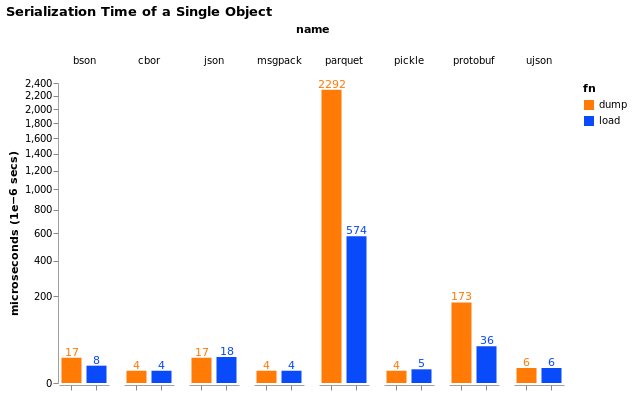

In [9]:
make_bars_chart(
    single_df,
    title='Serialization Time of a Single Object',
    sqrt_scale=True,
    labels=False,
)

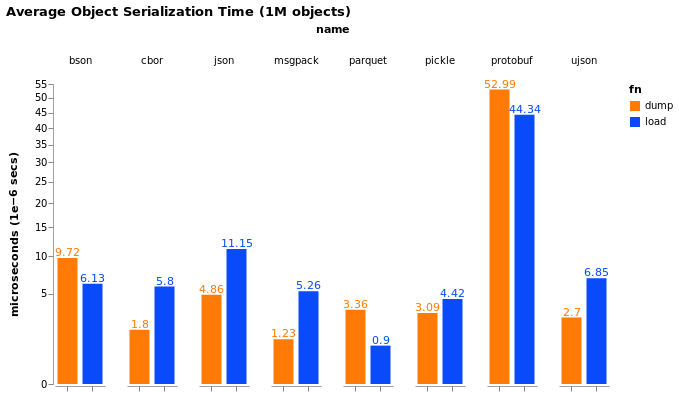

In [10]:
make_bars_chart(
    million_df,
    avg_col='avg_object',
    title='Average Object Serialization Time (1M objects)',
    sqrt_scale=True,
    labels=False,
)

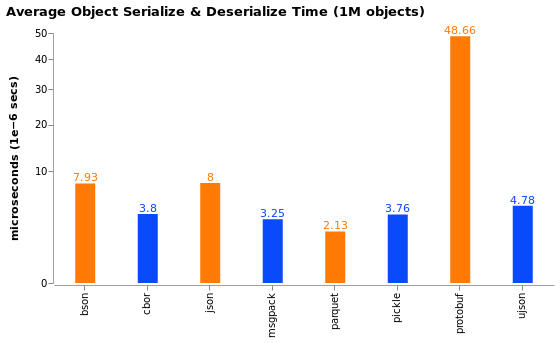

In [11]:
make_bars_chart(
    ser_mil_df,
    avg_col='avg_serde_object',
    title='Average Object Serialize & Deserialize Time (1M objects)',
    sqrt_scale=True,
    width=500,
    height=250,
    multi_bar=False,
    legend=False,
)

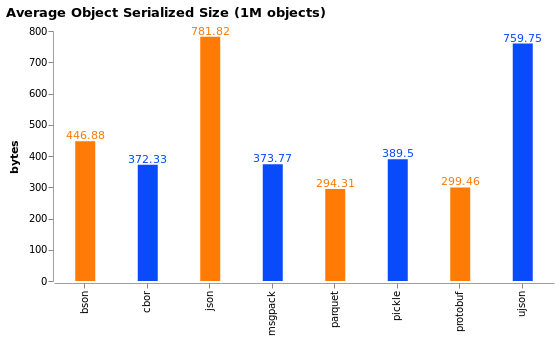

In [12]:
make_bars_chart(
    ser_mil_df,
    avg_col='avg_serialized_size',
    scale_title='bytes',
    title='Average Object Serialized Size (1M objects)',
    sqrt_scale=False,
    width=500,
    height=250,
    multi_bar=False,
    legend=False,
)